In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.signal import butter, lfilter, freqz

%matplotlib inline

In [2]:
class BECTdetect(object):
    
    def __init__(self, num, S_size, threshold, template_mode="pdf", NAME="S-BECT", print_log=True):
        self.NAME = NAME
        self.num = num
        self.threshold = threshold
        self.print_log = print_log
        
        self.path = os.getcwd() + "\\test_csv_data\\" + self.NAME
        self.filename = os.listdir(self.path)[self.num-1]
        self.filepath = self.path + "\\" + self.filename
        self.data, self.label, self.columns = self._read_csv()
#         self.label_ind = np.array(np.where(self.label == 1)[0])
        self.s_channel = self.get_s_channel()
        self.s_data = self.data[self.s_channel]
        
        self.window = S_size
        self.template_mode = template_mode
        self.pdf_distribution = "gamma"
        if self.template_mode == "pdf":
            self._template = self._get_pdf_template()
        
        self.pred_ind, self.output = self._bect_detection()
        self.indicator = self.get_indicator()
        
        self._print_output()
            
    def _read_csv(self):
        raw_data = pd.read_csv(self.filepath)
        data = raw_data.drop(["label"], axis=1)
        label = raw_data["label"].values
        columns = raw_data.columns.values[:-1]
        if self.print_log:
            print("File loading: \""+self.filepath+"\".")
            print("The length of the data is "+str(data.shape[0])+".")
        return data, label, columns
    
    def get_s_channel(self):
        s_channels = self.filename[:-12].split("-")
        channel_name = []
        for name in self.columns:
            for s_channel in s_channels:
                if s_channel in name:
                    channel_name.append(name)
        if self.print_log:
            print("The labeled S-BECT channel is \"",channel_name,"\".")
        return channel_name
    
    def _print_output(self):
        print(" ")
        print("**********{:s}***********".format(self.filename))
        print("Signal Length-->{:d} s;".format(int(self.s_data.shape[0]/1000)))
        for channel in self.s_channel:
            print("Pred_S in channel \"{:s}\"-->{:d}; Indicator-->{:.2f}%.".format(channel, int(len(self.pred_ind[channel])), self.indicator[channel]*100))
        print("Max indicator-->{:.2f}%; ".format(max(self.indicator.values())*100))
        print("Avg indicator-->{:.2f}%; ".format(sum(self.indicator.values())/len(self.indicator)*100))
        return None
    
    def _get_pdf_template(self):
        
        # Use beta distribution
        if self.pdf_distribution == "beta":
            alpha=2
            beta=3.2
            x = np.linspace(0,1,self.window)
            pdf = stats.beta(alpha, beta).pdf(x)
        
        # Use gamma distribution
        elif self.pdf_distribution == "gamma":
            x = np.linspace(0,4,self.window)
            pdf = stats.gamma.pdf(x, a=2.2)
            pdf = pdf**2
        return pdf
    
    def _triang_spike(self, x):
        
        minx = np.min(x, axis=1)
        maxx = np.max(x, axis=1)
        out = np.zeros(x.shape)
        mid_ind = int(self.windows*1/3)
        out[:, :mid_ind] = np.linspace(minx, maxx, mid_ind, axis=1)
        out[:, mid_ind:] = np.linspace(maxx, minx, length-mid_ind, axis=1)
        return out
    
    def _pdf_spike(self, x):
        minx = np.min(x, axis=1)
        maxx = np.max(x, axis=1)
        
        pdf = self._template 
        pdf = (pdf-min(pdf))/(max(pdf)-min(pdf))
        pdf = np.tile(pdf, [x.shape[0], 1])
        out = (pdf.T*(maxx-minx)+minx).T
        return out
    
    def _bect_detection(self):
        detection_length = 1000

        All_channels_pred_ind = {}
        All_channels_filted_data = {}

        for channel in self.s_channel:
        
            data = np.array(self.s_data[channel])
            
            N = int(np.ceil(len(data)/detection_length))
            datas = np.array_split(data[:-(len(data)-(N-1)*detection_length)], N-1)
            rest = len(data)-(N-1)*detection_length
            
            if rest >= self.window:
                datas = datas + [data[-(len(data)-(N-1)*detection_length):]]
                
            filted_data = np.zeros(data.shape)
            pred_ind = []   
            
            i = 0
            for x in datas:
                xx = self._window_slide(x)
                if self.template_mode == "pdf":
                    template = self._pdf_spike(xx)
                elif self.tmplate_mode == "triang":
                    template = self._triang_spike(xx)
                score = np.mean(xx*template, axis=1)
                expanded_score = np.hstack([np.zeros(int(self.window/2)), score, np.zeros(self.window-int(self.window/2)-1)])
                if i<len(datas)-1:
                    filted_data[i*x.shape[0]:(i+1)*x.shape[0]] = expanded_score
                else:
                    filted_data[-(len(datas)-i)*x.shape[0]:] = expanded_score

                outline_ind, flag, s= self._find_S_points(score)
                print(np.floor(i/5),"-->",flag, s)
                if len(outline_ind) > 0:
                    outline_ind += i * detection_length
                    pred_ind = pred_ind + list(outline_ind)
                i += 1
            pred_ind = np.array(pred_ind)
            All_channels_pred_ind[channel] = pred_ind
            All_channels_filted_data[channel] = filted_data

        return All_channels_pred_ind, All_channels_filted_data
    
    def _window_slide(self, x):
        stride = 1
        n = int((len(x)-(self.window-stride))/stride)
        out = np.zeros((n, self.window))
        for i in range(self.window-1):
            out[:,i] = x[i:-(self.window-1-i)]
        out = (out.T - np.mean(out, axis=1)).T
        return out
    
    def _find_S_points(self, score):
        dscore = score[1:]-score[:-1]
        
        peak_ind = np.where(dscore[:-1]*dscore[1:]<0)[0]
        peak_score = score[peak_ind]
        flag = 0
        
        if np.std(peak_score) < 220:
            outline_ind = []
        else:
            flag_score = (score - min(score))/(max(score)-min(score))-0.5
#             peak_ind_0 = [ind for i, ind in enumerate(peak_ind) if i%2==0]
#             peak_ind_1 = [ind for i, ind in enumerate(peak_ind) if i%2==1]
#             if len(peak_ind_0) > len(peak_ind_1):
#                 peak_ind_0 = peak_ind_0[:-1]
#             elif len(peak_ind_1) > len(peak_ind_0):
#                 peak_ind_1 = peak_ind_1[:-1]
#             assert(len(peak_ind_0)==len(peak_ind_1))
#             delta = np.abs(flag_score[peak_ind_1] - flag_score[peak_ind_0])
            delta = np.abs(flag_score[peak_ind[1:]] - flag_score[peak_ind[:-1]])
            delta = delta[np.where(delta < 0.8)[0]]
            flag = np.sum(delta) 

            if flag > 4.0:
                outline_ind = []
            else:
                n = self.threshold
                mean = np.mean(peak_score)
                std = np.std(peak_score)
                ind = np.where(abs(peak_score-mean)>n*std)[0]
                outline_ind = peak_ind[ind]
                ind = np.where(score[outline_ind]>0)[0]
                outline_ind = outline_ind[ind]
                outline_ind += int(self.window/2)
        return outline_ind, flag, np.std(peak_score)
        
    def get_indicator(self):

        window = 1000
        indicator = {}
        for channel in self.s_channel:
            length = self.s_data.shape[0]
            mask = np.zeros(length)
            mask[self.pred_ind[channel]] = 1
            N = int(length/window)
            rest = length%window
            mask = mask[:-rest]
            rest = mask[-rest:]
            split = mask.reshape(N, window)
            out = np.zeros(N+1)
            out[:N] = split.sum(axis=1)
            out[-1] = sum(rest)
            indicator[channel] = 1-(len(np.where(out==0)[0])/len(out))

        return indicator

    # def get_indicator(self):
    #     split_length = self.pred_ind[1:]-self.pred_ind[:-1]
    #     long_split_length = split_length[np.where(split_length>=2000)[0]]
    #     long_split_second = np.floor(long_split_length/1000)
    #     indicator = 1-(np.sum(long_split_second)*1000/len(self.s_data))
    #     return indicator
    
    def plot_result(self, slice_ind=None):
        if slice_ind == None:
            size = [0, len(self.s_data)-1]
        else:
            if slice_ind[1] > len(self.s_data)-1:
                slice_ind[1] = len(self.s_data)-1
            size = [slice_ind[0], slice_ind[1]]
        
        channel_num = len(self.s_channel)
        
        plt.figure(figsize=[15,3*channel_num])
        i = 0
        for channel in self.s_channel:
            i += 1
            plt.subplot(2*channel_num,1,i)
            plt.plot(self.s_data[channel][size[0]:size[1]], linewidth="1")
            plt.title("Signal of "+channel+" channel")
            
            i += 1
            plt.subplot(2*channel_num,1,i)
            plt.plot(np.arange(size[0],size[1]),self.output[channel][size[0]:size[1]])
            plt.title("Detection")
            for ind in self.pred_ind[channel]:
                if ind>=size[0] and ind<=size[1]:
                    plt.axvline(ind, c="g")
        plt.tight_layout()
        return None
    
    def plot_deep_image(self, slice_ind=None):
        if slice_ind == None:
            size = [0, len(self.s_data)-1]
        else:
            if slice_ind[1] > len(self.s_data)-1:
                slice_ind[1] = len(self.s_data)-1
            size = [slice_ind[0], slice_ind[1]]
        
        channel_num = len(self.s_channel)
        
        plt.figure(figsize=[15,3*channel_num])
        i = 0
        for channel in self.s_channel:
            i += 1
            plt.subplot(channel_num,1,i)
            x = np.array(self.s_data[channel][size[0]:size[1]])
            x = x.reshape(-1, 1)
            x = np.concatenate([-(x-xi) for xi in x], axis=1)
            y1 = np.triu(x)
            y2 = -np.tril(x)
            y3 = np.eye(len(x))*x
            x = y1+y2+y3
            plt.imshow(x)
            plt.title("Signal of "+channel+" channel")
        plt.tight_layout()
        return None
        

973393576784
140.0 --> 2.669357475567862 1109.0229285220657
140.0 --> 2.3046962633147405 620.7043225214787
140.0 --> 3.295804720249093 2480.5923391164383
141.0 --> 0 172.53967880181145
141.0 --> 0 162.51799813547737
141.0 --> 3.522419113133515 1227.536524665468
141.0 --> 0 93.38443812271123
141.0 --> 1.6237307840146036 1230.278623238895
142.0 --> 1.9293252223810404 575.454059437804
142.0 --> 1.0246155199971143 1285.0353110261915
142.0 --> 1.0687798742647567 1870.8731492301515
142.0 --> 2.767700880663281 1558.4204227837356
142.0 --> 1.9933801813118743 1008.4672172312523
143.0 --> 4.000182100685275 275.16049116404054
143.0 --> 2.0414921901216356 2504.9170841936507
143.0 --> 1.8262311447935133 925.1043980653741
143.0 --> 1.2352307014979984 1393.629545072545
143.0 --> 1.6894913210570697 754.171426689004
144.0 --> 3.9364479937015444 284.6633518737194
144.0 --> 1.6577884728044916 540.7895199695305
144.0 --> 2.781532923221256 581.9491481294838
144.0 --> 2.13183954190735 1551.9879421103299
144

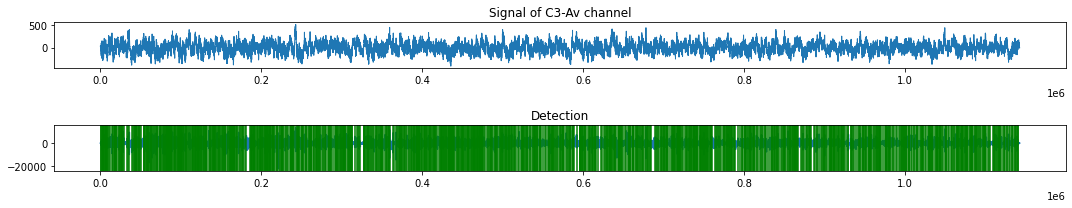

In [3]:
bect = BECTdetect(num=4, S_size=61, threshold=2)
bect.plot_result()

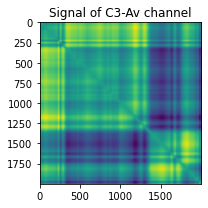

In [69]:
i = 15
bect.plot_deep_image([i*2000,(i+1)*2000])

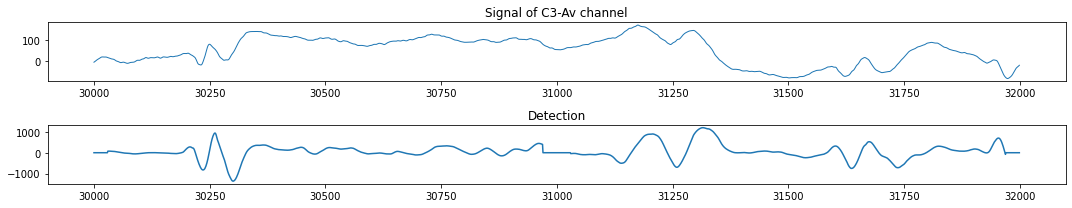

In [70]:
# i = 5,6,7,8,9,19,22,23
bect.plot_result([i*2000,(i+1)*2000])

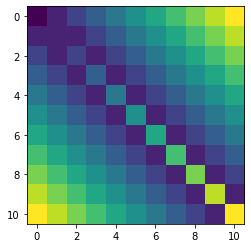

In [71]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
x = x.reshape(-1,1)
y = np.concatenate([-(x-xi) for xi in x], axis=1)
y1 = np.triu(y)
y2 = -np.tril(y)
y3 = np.eye(len(x))*x
y = y1+y2+y3
plt.imshow(y)